# Recherche modèles de prédiction en séquences

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

2024-02-14 21:28:10.664951: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Extrait les dernières données et écrit le dataset

In [2]:
from lib.dataeng import Etl

In [3]:
etl = Etl()

df_weight_raw, df_food_raw, df_exos_raw, df_all = etl.extract_store_all()


Le fichier poids le plus récent est : data_BEN_1707889990.zip, parmi :
data_BEN_1707889990.zip
data_BEN_1707727886.zip
data_BEN_1707810693.zip

Le fichier food le plus récent est : File-Export-2020-08-03-to-2024-02-14.zip, parmi
File-Export-2020-08-03-to-2024-02-14.zip
File-Export-2020-08-03-to-2024-02-13.zip
File-Export-2020-08-03-to-2024-02-12.zip

Le fichier exercices le plus récent est : polar-user-data-export_703c11e2-d0c0-42d0-84a6-665ce3a9f847.zip, parmi :
polar-user-data-export_12baa4ce-79a5-40f8-ad40-74308f7c2c26.zip
polar-user-data-export_703c11e2-d0c0-42d0-84a6-665ce3a9f847.zip


100%|██████████| 1868/1868 [01:11<00:00, 26.19it/s]


In [4]:
fullds_path = '/home/benjamin/Folders_Python/Weight/data/full_dataset.csv'

with open(fullds_path, 'r') as f:
    df_full = pd.read_csv(f, index_col=0)
    
cols_to_drop = ['Masse_Osseuse', 'Masse_Musculaire', 'Masse_Hydrique']
df_full.drop(columns=cols_to_drop, inplace=True)
df_full.dropna(inplace=True)

In [5]:
df_full.describe(include='all').transpose()

,count,mean,std,min,25%,50%,75%,max
Masse_Totale,1267.0,73.729102,7.735341,66.000000,69.270417,71.378571,73.282857,107.250000
Masse_Grasse,1267.0,12.190441,5.134425,7.541667,8.957167,10.872000,12.184286,37.190000
MG%,1267.0,0.160871,0.043731,0.112927,0.128995,0.151650,0.167486,0.346760
BMR,1267.0,1699.235077,59.015702,1626.348571,1664.285500,1679.284000,1705.405600,1933.516000
Calories,1267.0,1966.618074,457.444515,0.300000,1779.500000,1849.800000,2038.150000,5762.000000
Lipides,1267.0,52.765193,22.358508,0.000000,38.500000,49.300000,63.900000,235.900000
Glucides,1267.0,212.899763,75.502068,0.100000,168.450000,198.600000,240.850000,875.400000
Proteines,1267.0,157.270166,39.874736,0.000000,134.250000,162.200000,184.550000,267.100000
exo_duree,1267.0,2695.146783,2789.985837,0.000000,0.000000,2340.736000,4733.468000,28800.000000
exo_cals_bruts,1267.0,295.503552,294.755473,0.000000,0.000000,277.000000,496.000000,2290.000000


In [6]:
ds = df_full[['Calories', 'exo_cals_nets', 'Masse_Totale', 'Masse_Grasse']]

In [7]:
ds

,Calories,exo_cals_nets,Masse_Totale,Masse_Grasse
2020-08-09,1861.3,0.000000,107.250000,37.190000
2020-08-11,1772.4,0.000000,104.650000,33.150000
2020-08-12,1894.3,0.000000,104.350000,33.800000
2020-08-13,1822.6,0.000000,104.400000,34.340000
2020-08-14,1891.5,0.000000,104.500000,33.850000
...,...,...,...,...
2024-02-09,1687.3,209.483420,72.121333,12.070000
2024-02-10,2370.6,345.293552,72.171333,12.149333
2024-02-11,1794.8,415.607489,72.368000,12.071333
2024-02-12,2687.5,414.377460,73.057333,12.326667


In [8]:
# from lib.librnn import CreateDataset  # utilisation de tf.dataset : compliqué
# essai = CreateDataset(ds)
# essai.dataframe.head(20)

# dsf = essai.create_dataset()

### création dataset

On créé un dataset pour des modèles de sequence-to-sequence.

Hyperparamètres :
- PAST = longueur (en jours) de l'historique que l'on va prendre en entrée. Détermine la longueur de la séquence en entrée.
- FUTURE = longueur (en jours) de la fenêtre sur laquelle on veut prédire. Longueur de la séquence en sortie

Description :
- INPUTS : au timestep d'indice i, c'est une séquence (vecteur) concaténation de:
  - la séquence de longueur PAST, indices de i-PAST+1 à i (inclus) des features exo_cals_nets, Calories, Masse_Totale, Masse_Grasse
  - la séquence de longueur FUTURE, indices de i+1 à i+FUTURE (inclus) des features exo_cals_nets, Calories
- OUTPUTS : les valeurs cibles au timestep d'indce sont une séquence (vecteur):
  - séquence de longueur FUTURE, formée des indices i+1 à i+FUTURE des valeurs Masse_Totale, Masse_Grasse

Le modèle vont apprendre sur des séquences formées de tous les inputs passés (calories exercices, food, masses) et des inputs prévus dans le futur (calories exercices et food) pour prévoir les masses dans le futur

In [9]:
class CreateDataset2():
    
    # default values
    PAST = 2
    FUTURE = 1
    
    def __init__(self, dataframe,  past=None, future=None):
        """Créé le dataset avec paramètres : 
        <past> est le nombre de jours de données passées : calories food, exercices, masses totale grasse
        <futur> est le nombre de jours où l'on veut prédire masse totale et masse grasse
        Les inputs sont formés de (calories_food, calories_exercices, masse_totale, masse_grasse) sur toute la durée past 
        ET les données (calories_food, calories_exercices) sur la période de <futur - 1> jours.
        les outputs sont les (masse_totale, masse_grasse) sur le futur

        Args:
            dataframe (pd.Dataframe): dataframe des données d'entrée. Index formé de datetimes. Colonnes : 'exo_cals_nets', 'Calories', 'Masse_Totale', 'Masse_Grasse'
            past (int, optional): nombre de jours dans le passé. Defaults to None.
            future (int, optional): nombre de jours dans le futur pour la prévision. Defaults to None
        """
        
        self.data = dataframe
        self.past = self.PAST if past is None else past
        self.future = self.FUTURE if future is None else future
        
    def create_dataset(self):
        """construit et retourne le dataset
        """
        id_start = self.past - 1  # plus petit indice à paritr duquel on peut itérer la construction = indice rang de départ
        id_stop = len(self.data) - self.future - 1 # indice max : plus grand indice jusqu'au quel on peut itérer
        
        n_timesteps = id_stop - id_start
        n_features = self.past * 4 + (self.future - 1) * 2 # dimension du vecteur input à chaque timestep
        output_dim = self.future * 2 # dimension vecteur sortie
        
        inputs = np.zeros(shape=(n_timesteps, n_features))  # la sortie sera un np.array de shape n_timesteps
        outputs = np.zeros(shape=(n_timesteps, output_dim))
        
        for i in range(id_start, id_stop):
            # print(id_start, id_stop, i, i-self.past, i+1, i+self.future +1)
            x1 = self.data.iloc[i-self.past+1:i+1,:].to_numpy().flatten()
            # print(x1.shape)
            x2 = self.data.iloc[i+1:i+self.future,:2].to_numpy().flatten()
            # print(x2.shape)
            x = np.concatenate([x1, x2])
            inputs[i-id_start] = x
            # print(self.data.iloc[i+1:i+self.future+2,-2:].to_numpy().flatten())
            outputs[i-id_start] = self.data.iloc[i+1:i+self.future+1,-2:].to_numpy().flatten()
            
        df = pd.DataFrame(data = np.concatenate((inputs, outputs), axis=1), index=ds.index[self.past:-self.future])
        
        columns_names = [ f'input_{i}' for i in range(inputs.shape[1]) ] + [ f'outputs_{i}' for i in range(outputs.shape[1]) ]
        # print(columns_names)
        df.columns = columns_names
            
        return inputs, outputs, df
    
    def __repr__(self) -> str:
        output = f'dataset longueur {len(self.data)} jours\n' + f'de {self.data.index[0]} à {self.data.index[-1]}\n' \
            + f'PAST = {self.past}, FUTUR = {self.future}'
        return output

In [10]:
e = CreateDataset2(ds, past=3, future=2)

In [11]:
e

dataset longueur 1267 jours
de 2020-08-09 à 2024-02-13
PAST = 3, FUTUR = 2

In [12]:
inputs, outputs, df = e.create_dataset()

In [13]:
ds.tail(12)

,Calories,exo_cals_nets,Masse_Totale,Masse_Grasse
2024-02-02,1712.0,314.605929,72.486000,12.187333
2024-02-03,1830.5,263.491712,72.394286,12.155000
2024-02-04,1746.8,468.083444,72.766667,12.566667
2024-02-05,1709.9,0.000000,72.806000,12.340000
2024-02-06,1737.7,335.689293,73.715333,12.574000
2024-02-07,1851.8,295.374778,73.004667,11.967333
2024-02-08,1613.4,0.000000,72.600000,12.451875
2024-02-09,1687.3,209.483420,72.121333,12.070000
2024-02-10,2370.6,345.293552,72.171333,12.149333
2024-02-11,1794.8,415.607489,72.368000,12.071333


In [14]:
df.tail(20)

,input_0,input_1,input_2,input_3,input_4,input_5,input_6,input_7,input_8,input_9,input_10,input_11,input_12,input_13,outputs_0,outputs_1,outputs_2,outputs_3
2024-01-23,1771.0,415.300451,72.846667,12.586667,2014.0,297.844003,72.544167,12.618333,1714.6,307.409505,72.324167,12.001667,1656.9,0.000000,72.640000,12.190833,72.864167,12.309167
2024-01-24,2014.0,297.844003,72.544167,12.618333,1714.6,307.409505,72.324167,12.001667,1656.9,0.000000,72.640000,12.190833,1731.9,373.559858,72.864167,12.309167,73.599167,12.578333
2024-01-25,1714.6,307.409505,72.324167,12.001667,1656.9,0.000000,72.640000,12.190833,1731.9,373.559858,72.864167,12.309167,1803.3,161.198547,73.599167,12.578333,73.905833,12.539167
2024-01-26,1656.9,0.000000,72.640000,12.190833,1731.9,373.559858,72.864167,12.309167,1803.3,161.198547,73.599167,12.578333,1778.6,226.307982,73.905833,12.539167,73.350000,12.182857
2024-01-27,1731.9,373.559858,72.864167,12.309167,1803.3,161.198547,73.599167,12.578333,1778.6,226.307982,73.905833,12.539167,1775.9,300.393829,73.350000,12.182857,73.339167,12.444167
2024-01-28,1803.3,161.198547,73.599167,12.578333,1778.6,226.307982,73.905833,12.539167,1775.9,300.393829,73.350000,12.182857,1821.9,294.128988,73.339167,12.444167,73.896667,12.780000
2024-01-29,1778.6,226.307982,73.905833,12.539167,1775.9,300.393829,73.350000,12.182857,1821.9,294.128988,73.339167,12.444167,1795.7,181.483944,73.896667,12.780000,73.340000,12.521538
2024-01-30,1775.9,300.393829,73.350000,12.182857,1821.9,294.128988,73.339167,12.444167,1795.7,181.483944,73.896667,12.780000,1680.9,0.000000,73.340000,12.521538,73.571538,12.973077
2024-01-31,1821.9,294.128988,73.339167,12.444167,1795.7,181.483944,73.896667,12.780000,1680.9,0.000000,73.340000,12.521538,1682.0,332.372089,73.571538,12.973077,73.963333,12.926667
2024-02-01,1795.7,181.483944,73.896667,12.780000,1680.9,0.000000,73.340000,12.521538,1682.0,332.372089,73.571538,12.973077,1664.6,160.687639,73.963333,12.926667,72.486000,12.187333


# Modèles pour J+1

In [41]:
e = CreateDataset2(ds, past=7, future=1)  # future = 1 day, pour commencer

print(e)

inputs, outputs, df = e.create_dataset()

dataset longueur 1267 jours
de 2020-08-09 à 2024-02-13
PAST = 7, FUTUR = 1


In [42]:
# basic test train split

cols_X = [ n for n in df.columns if n[:5]=="input" ]
cols_y = [ n for n in df.columns if n[:6]=="output" ]
X = df[cols_X]
y = df[cols_y]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [43]:
X_test.head(5)

,input_0,input_1,input_2,input_3,input_4,input_5,input_6,input_7,input_8,input_9,...,input_18,input_19,input_20,input_21,input_22,input_23,input_24,input_25,input_26,input_27
2020-11-08,1876.6,0.000000,91.016667,23.863333,1900.1,0.000000,90.966667,23.696667,1881.8,0.000000,...,90.883333,22.660000,1860.1,0.000000,90.666667,22.446667,2302.7,0.000000,90.083333,23.250000
2023-06-25,1886.9,261.146072,72.694286,11.278571,1518.4,331.337876,72.164444,11.558889,1789.2,208.231029,...,73.568571,11.154286,1704.5,245.200453,72.932857,10.575714,1753.4,319.907648,72.570000,11.574286
2020-10-06,1802.6,0.000000,97.683333,26.603333,1824.2,0.000000,97.450000,26.040000,1913.9,0.000000,...,95.800000,27.093333,1838.9,0.000000,95.650000,27.013333,1851.2,0.000000,95.350000,26.803333
2022-06-29,1867.9,357.807170,70.420833,9.088333,1873.0,378.525534,69.793333,8.855333,1836.2,419.744144,...,70.100000,8.748462,2114.2,471.216258,70.254167,9.179167,1855.1,434.207654,69.557692,9.386154
2022-02-10,1801.0,293.497571,68.050000,8.554167,1964.3,250.655080,68.080769,8.471538,2224.3,582.809506,...,68.785714,8.616429,2004.9,311.495865,68.554167,8.618333,1983.2,443.982011,68.262500,8.517500


In [44]:
y_test.head(5)

,outputs_0,outputs_1
2020-11-08,90.483333,21.156667
2023-06-25,72.637778,11.718889
2020-10-06,95.500000,26.630000
2022-06-29,69.633333,9.443333
2022-02-10,68.338462,8.436923


### baseline : prédiction à J+1 = valeurs à J

In [45]:
# sur X_test

y_pred = X_test.iloc[:,-2:]

In [46]:
def evaluate(y_pred, y_test, titre):
    """utility function pour calculer MSE et afficher"""
    mse = tf.keras.losses.MeanSquaredError()
    erreur = mse(y_test, y_pred).numpy()
    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,6))

    ax[0].scatter(y_pred.iloc[:,0], y_test.iloc[:,0], label='Masse Totale (pred v truth)')
    ax[0].plot([60,110],[60,110], marker='.', color='green', label='pred=truth')
    ax[0].grid(True)
    ax[0].legend()

    ax[1].scatter(y_pred.iloc[:,1], y_test.iloc[:,1], label='Masse Grasse (pred v truth)')
    ax[1].plot([8,35],[8,35], marker='.', color='green', label='pred=truth')
    ax[1].grid(True)
    ax[1].legend()

    title = titre + f'MSE (test set)= {erreur:.3f}'
    fig.suptitle(title)
    
    return erreur, fig, ax


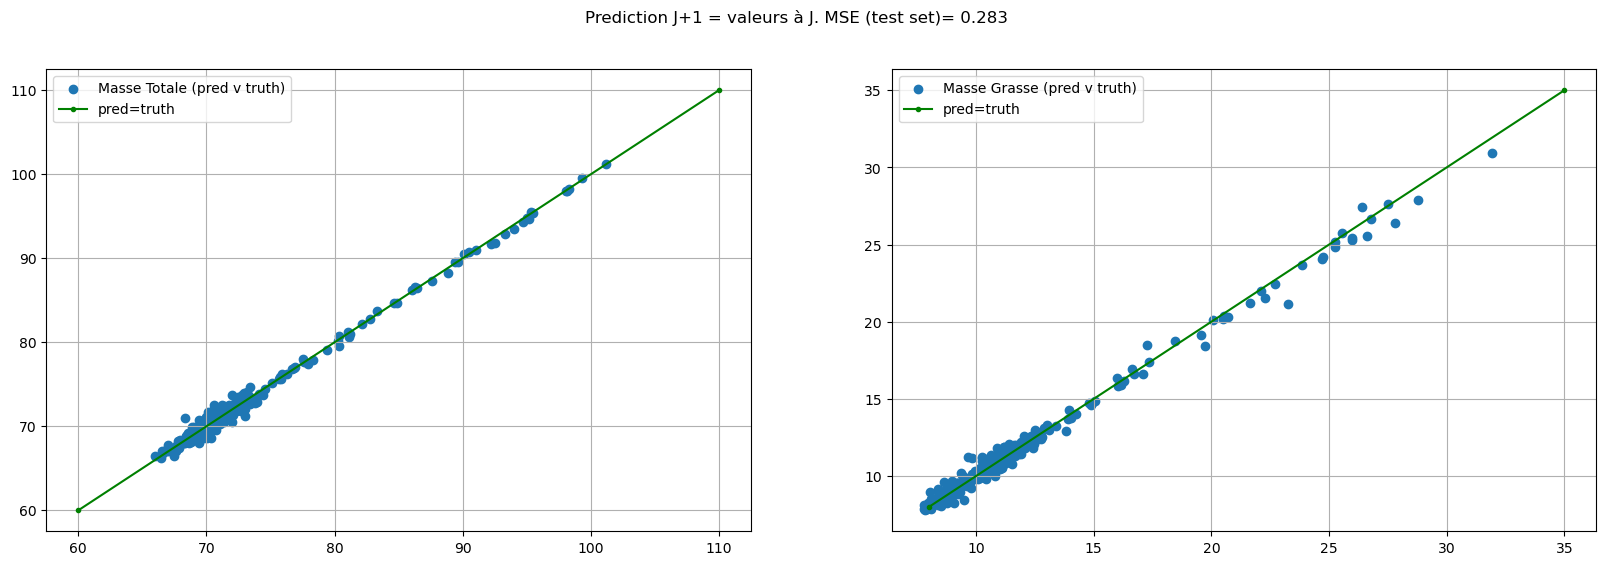

In [47]:
erreur, fig, ax = evaluate(y_pred, y_test, 'Prediction J+1 = valeurs à J. ')

### Regression Linéaire

In [48]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [49]:
y_pred = pd.DataFrame(lr.predict(X_test))

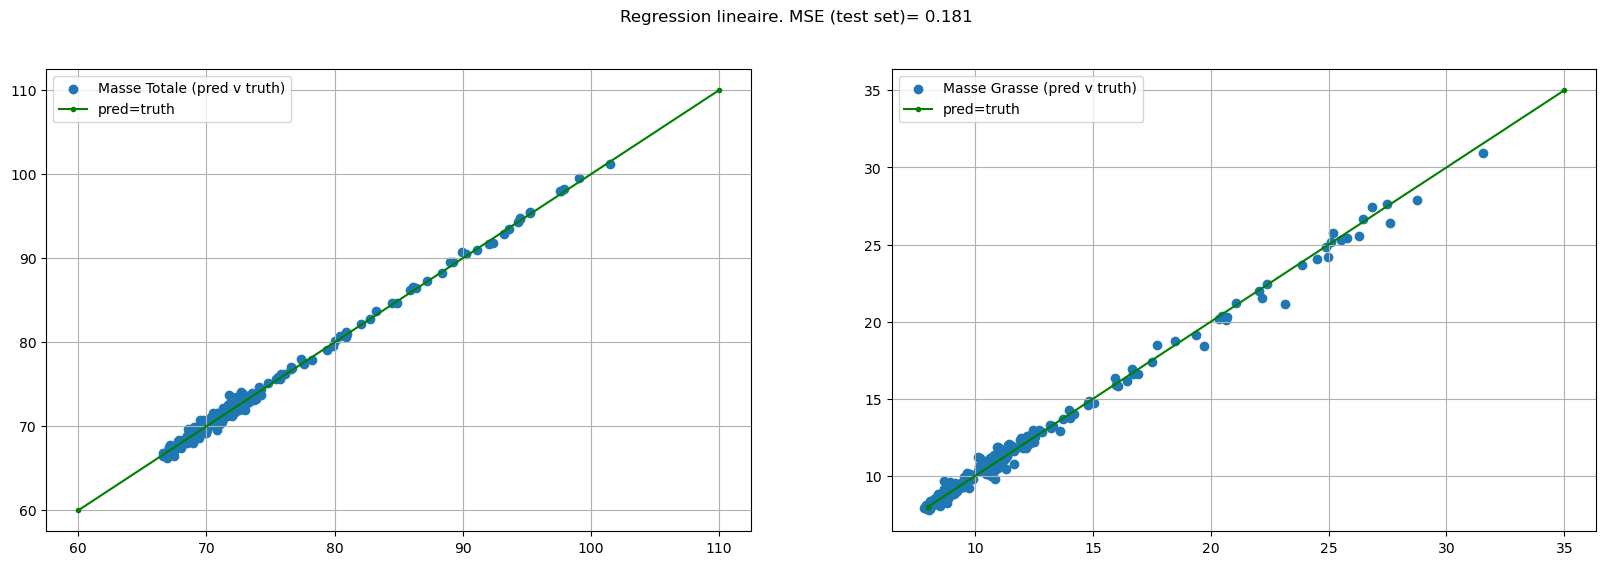

In [50]:
erreur, fig, ax = evaluate(y_pred, y_test, 'Regression lineaire. ')